<a href="https://colab.research.google.com/github/ahalyasanjiv/ChildhoodLeadExposure/blob/master/Linear_Regression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression Model 

In our data exploration, we have investigated the link between lead exposure and the demographic makeup, poverty level, and housing related data for a neighborhood.

Now we want to use what we learned from that to create a model that will allow us to predict the level of risk a neighborhood has for lead exposure.

In this notebook, we will be creating a **linear regression model**, which as we defined in class, is a method to model the relationship between a set of independent variables 𝑋 (also knowns as explanatory variables, features, predictors) and a dependent variable 𝑌 .

To do this, we will use numpy, statsmodels, and scikit-learn.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

%matplotlib inline

To summarize:

We found that in the NYS data (by zip code), there was a link found between the demographic percentages and the lead levels.

Features with positive correlations found between with incidences of elevated lead found in childhood blood:
- Percentage of blacks/African-Americans (0.28)
- Percentage of people who belong to two or more races (0.19)
- Percentage of people of Hispanic/Latino origin (0.12)
- Percentage of people who live below the poverty line (0.10).

Features with negative correlation found between incidences of elevated lead found in childhood:
- Percentage of white people living in a neighborhood (- 0.23). 

In the nation-wide data collected for 26 states (by county), the percentage of hispanics living in the county had the most significant correlation with the percentage of children with levels higher than 5 ug/dl (0.39!). Correlation with the percentage of whites living in the county had a negative correlation of -0.19, which is relatively close to what was found in the NYS data.

The correlation with income and poverty was at around -0.11 for income and 0.12 for poverty.

When looking at housing data for the United States for the percentage of houses built before a certain date, we found a slightly positive correlation.



To build the model, we will use NY State data by zip code. Ideally, we would like to use census tract data to allow for greater granularity, but we have only found lead data by zip code. The nation-wide data we found was by county, which although was useful for the sake of data exploration, it is not nearly as granular as we would like the model to be. 

In [0]:
# Read the dataset that was created from merged/cleaned lead level and demographics data for NYS by zip code (Refer to Investigating_Correlation_Between_Lead_Exposure_and_Demographics.ipynb)
lead_df = pd.read_csv('https://raw.githubusercontent.com/ahalyasanjiv/ChildhoodLeadExposure/master/data/NYS_Lead_Levels_and_Demographics.csv')
# Read the cleaned housing data for NYS by zip code
housing_df = pd.read_csv('https://raw.githubusercontent.com/ahalyasanjiv/ChildhoodLeadExposure/master/data/Housing_Units_Built_Pecentage_by_Year.csv')

Let's join the datasets on the zip code column.

In [13]:
df = lead_df.set_index('Zip Code').join(housing_df.set_index('Zip'), how='inner')
df.corr()['Percent Elevated Lead Cases'][1:]

One race - White                                                                            -0.228129
One race - Black or African American                                                         0.282719
One race - American Indian and Alaska Native                                                -0.005676
One race - Asian                                                                             0.032635
One race - Native Hawaiian and Other Pacific Islander                                       -0.022942
One race - Some other race                                                                   0.094792
Two or more races                                                                            0.188702
Hispanic or Latino origin (of any race)                                                      0.126239
White alone, not Hispanic or Latino                                                         -0.211089
Median Income                                                                     

We some contenders for predictors of lead exposure:
- Percentage of population that is black or African American (+ correlation)
- Percentage of population that is Hispanic or Latino origin (+ corrrelation)
- Percentage of population that is white (- correlation)
- Percentage of housing units built before 1950 (+ correlation)
- Percentage of population living below the poverty line (+ correlation)

## Single Variable Linear Regression Model
First, let's try a simple model using one feature as the predictor - percentage of blacks/African-Americans, since it has the highest correlation coefficient with 'Percent Elevated Lead Cases'.

We will use numpy's polyfit function to accomplish this.

In [14]:
# Get slope and intercept for the model
beta, alpha = np.polyfit(df['One race - Black or African American'], df['Percent Elevated Lead Cases'], 1)
print('beta: %0.3f, alpha: %0.3f.' % (beta, alpha))


beta: 0.105, alpha: 1.079.


Let's see how well this line fits the data.

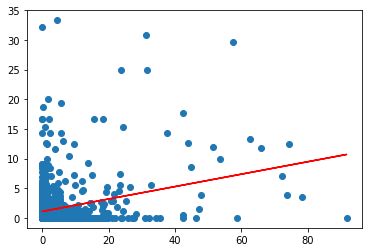

In [15]:
y = df['One race - Black or African American']*beta + alpha

_ = plt.scatter(df['One race - Black or African American'], df['Percent Elevated Lead Cases'])
_ = plt.plot(df['One race - Black or African American'], y, color='r')

plt.show()

To get a better idea of the error, we will use the residual difference between the predicted percentage of elevated lead cases and the actual percentage.

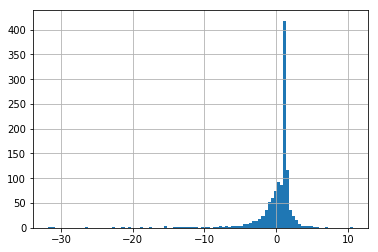

In [16]:
df['predicted_elevated_lead_percentage'] = df['One race - Black or African American'] * beta + alpha
df['residual_elevated_lead_percentage'] = df['predicted_elevated_lead_percentage'] - df['Percent Elevated Lead Cases']
df['residual_elevated_lead_percentage'].hist(bins=100)

The residual percentage clustered mostly around about 2%. 

## Using statsmodel For Multiple Linear Regression


In [17]:
df = sm.add_constant(df)

# First let's try single variable linear regression with the previous variable we used
est = sm.OLS(df['Percent Elevated Lead Cases'], 
             df[['const', 'One race - Black or African American']]
            ).fit()

print(est.summary())

                                 OLS Regression Results                                
Dep. Variable:     Percent Elevated Lead Cases   R-squared:                       0.080
Model:                                     OLS   Adj. R-squared:                  0.079
Method:                          Least Squares   F-statistic:                     102.8
Date:                         Tue, 14 May 2019   Prob (F-statistic):           3.24e-23
Time:                                 22:24:31   Log-Likelihood:                -3047.3
No. Observations:                         1185   AIC:                             6099.
Df Residuals:                             1183   BIC:                             6109.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [28]:
# Adding other variables to our model
est = sm.OLS(df['Percent Elevated Lead Cases'], 
             df[['const', 'One race - Black or African American',
                 '% of housing units built before 1950',
                'Hispanic or Latino origin (of any race)',
                'One race - White',
                 'Two or more races',
                'Total Housing Units']]
            ).fit()

df.columns
print(est.summary())

                                 OLS Regression Results                                
Dep. Variable:     Percent Elevated Lead Cases   R-squared:                       0.146
Model:                                     OLS   Adj. R-squared:                  0.142
Method:                          Least Squares   F-statistic:                     33.59
Date:                         Tue, 14 May 2019   Prob (F-statistic):           1.50e-37
Time:                                 22:29:24   Log-Likelihood:                -3003.1
No. Observations:                         1185   AIC:                             6020.
Df Residuals:                             1178   BIC:                             6056.
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------